Index(['Created At', 'Result', 'Map', 'Kills', 'Assists', 'Deaths',
       'Headshots', 'Double Kills', 'Triple Kills', 'Quadro Kills',
       'Penta Kills', 'K/D Ratio'],
      dtype='object')


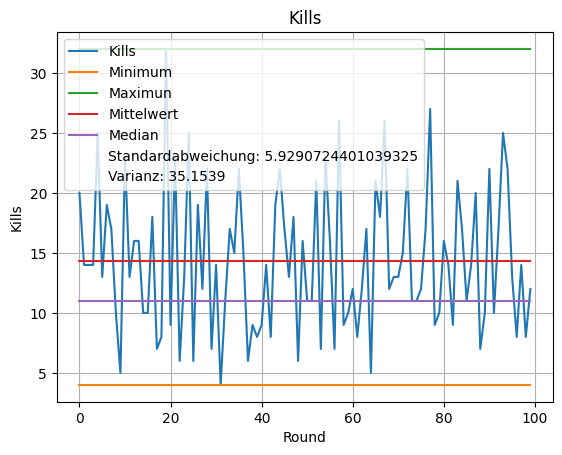

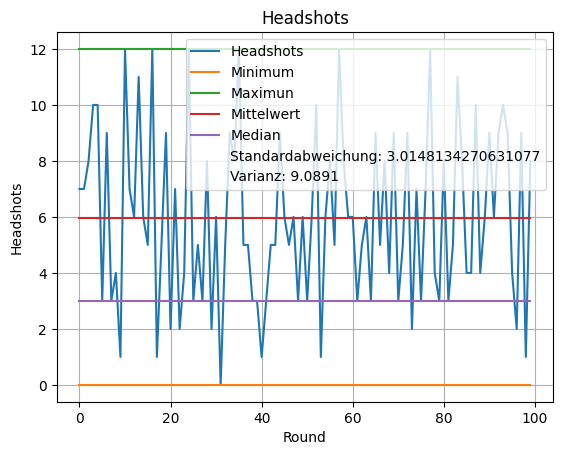

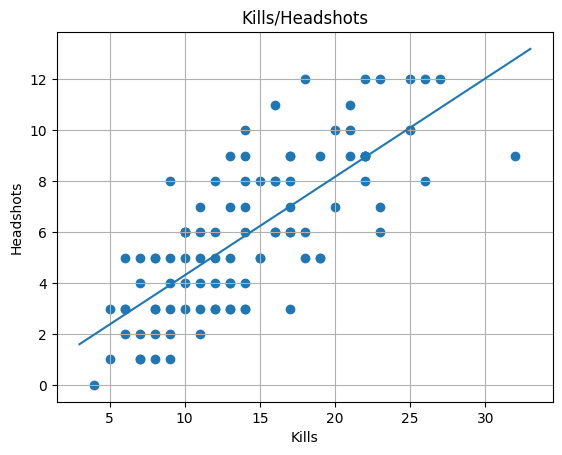

Korrelation:0.7602385518810532


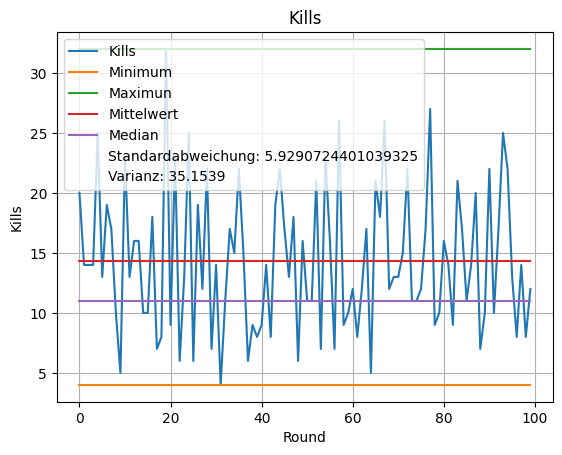

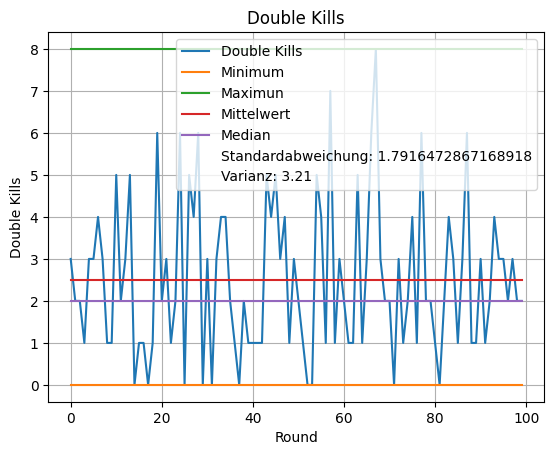

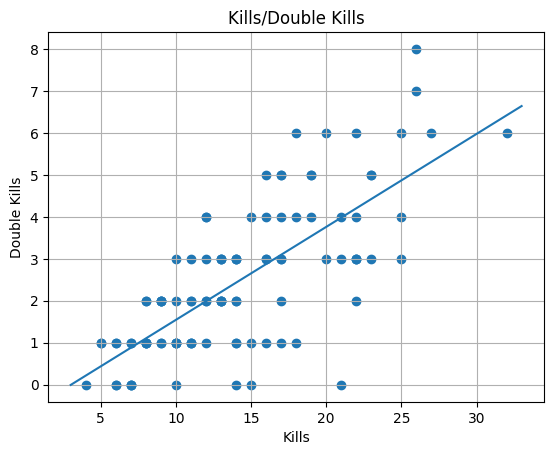

Korrelation:0.732857175108394


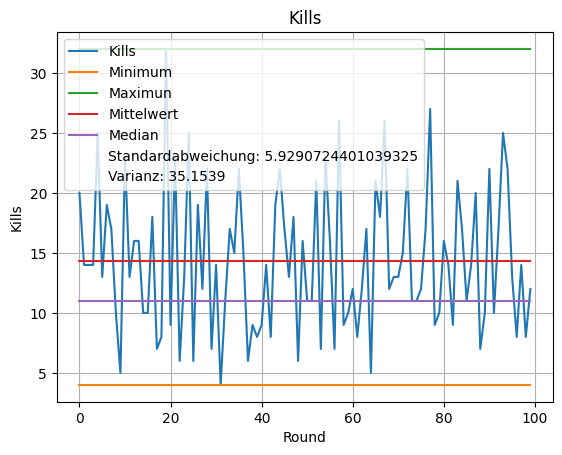

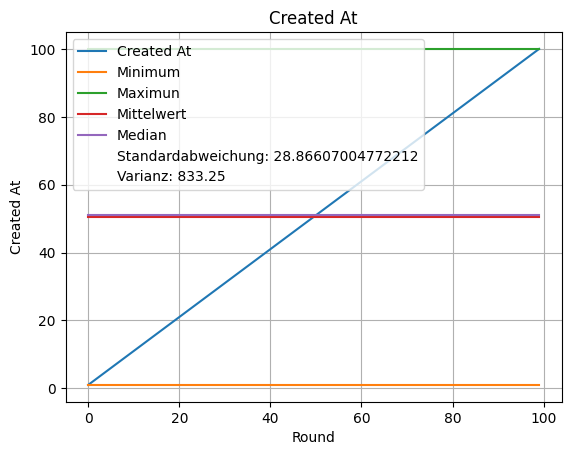

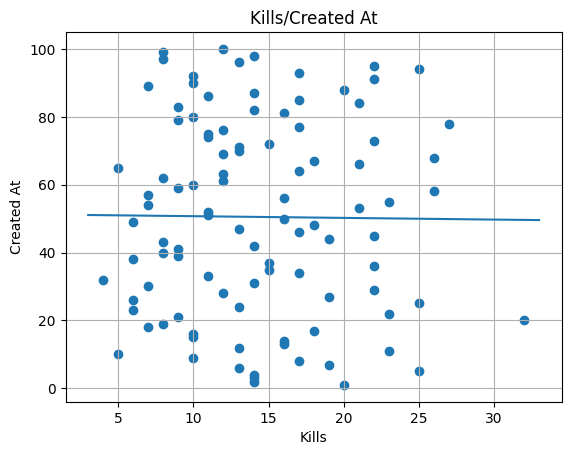

Korrelation:-0.010254221707867906
0.675


In [7]:
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from scipy import stats
import seaborn as sns

# Read Data from csv
data = pd.read_csv("faceit_match_data.csv", index_col=0)

def translate_strings_to_ints(data):
    """
    Translates strings in the input list to integers and returns a new list with the translated data.
    
    Parameters:
    data (list): The input list containing strings, integers, or floats.
    
    Returns:
    list: A new list with strings translated to integers.
    dict: A dictionary mapping the original strings to their corresponding integer values.
    """
    translated_data = []
    string_to_int = {}
    current_int = 1
    
    for item in data:
        if isinstance(item, str):
            if item not in string_to_int:
                string_to_int[item] = current_int
                current_int += 1
            translated_data.append(string_to_int[item])
        else:
            translated_data.append(item)
    
    return translated_data


# mache vorhersage aufgrund der daten
# eingabe: karte
# errechne gewinnwahrscheinlichkeit für die karte: wins auf Karte / (alle matches auf karte)
# vorhersage kills auf der karte
# bishreige kills, lineare regression und dann vorhersage?
# vorhersage Tode auf der karte
# ...

print(data.columns)
#print(data)

def getWinProbabilityOfMap(data:pd, map):
    mapData = data.loc[(data['Map'] == map)]
    wins = mapData.loc[(data['Result'] == 1)]
    loses = mapData.loc[(data['Result'] == 0)]
    winRate = len(wins) / (len(wins) + len(loses))
    return winRate

'''
    Lineare Regression: (Ausgleichsgerade für Datenpunkte die nicht auf einer gerade liegen)
        - Least squares:
            a_star = 𝜎_𝑥𝑦/𝜎²_𝑥
            b_star = y_mean - aStern *x_mean

            x = np.array([np.min(X) - 1, np.max(X) + 1]) 
            y = a_star * x + b_star
            plt.plot(x, y)  # Gerade plotten
'''

def median(x):
    i = len(x)/2
    if np.isclose(i, round(i)):#i ungerade
        i = round(i)
        return x[i]
    else:# i gerade
        i = int(i)
        return (x[i] + x[i+1])/2

def quantile(x,p):
    n = len(x)
    i = n*p
    if np.isclose(i, round(i)):#ungerade
        i = round(i)
        return x[i] 
    else:
        i = int(i)
        return (x[i] + x[i+1])/2

def covariance(x,y):
    x_mean = sum(x)/len(x)
    y_mean = sum(y)/len(y)
    return sum([(x[i] - x_mean)*(y[i] - y_mean) for i in range(len(x))]) / len(x)

def variance(X):
    x_mean = sum(X)/len(X)
    return sum([(x - x_mean)**2 for x in X]) / len(X)

def standardDeviation(x):
    return math.sqrt(variance(x))

def least_squares(x,y):
    a_star = covariance(x,y)/variance(x)
    x_mean = sum(x) /len(x)
    y_mean = sum(y) /len(y)
    
    b_star = y_mean - a_star * x_mean 

    return a_star, b_star

def correlation(x,y):
    return covariance(x,y) / (standardDeviation(x) * standardDeviation(y))

def plotFeature(feature:str):
    #Kill Statistik
    kills = translate_strings_to_ints(data[feature])
    plt.plot(kills, label=feature)
    plt.plot(np.linspace(min(kills), min(kills), 100), label="Minimum")
    plt.plot(np.linspace(max(kills), max(kills), 100), label="Maximun")
    plt.plot(np.linspace(np.mean(kills), np.mean(kills), 100), label="Mittelwert")
    plt.plot(np.linspace(median(kills), median(kills), 100), label="Median")
    plt.plot([], [], ' ', label= "Standardabweichung: " +str(standardDeviation(kills)))
    plt.plot([], [], ' ', label= "Varianz: " + str(str(variance(kills))))
    plt.grid()
    plt.legend()
    plt.xlabel("Round")
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

def plot2Features(featureA,featureB):
    # Kills/Deaths scatter plot 
    kd = data[[featureA,featureB]]
    kills = translate_strings_to_ints(kd[featureA])
    deaths = translate_strings_to_ints(kd[featureB])

    plt.scatter(kills,deaths)
    a_star, b_star = least_squares(np.array(kills),np.array(deaths))
    x = np.array([np.min(kills) - 1, np.max(kills) + 1]) 
    y = a_star * x + b_star
    plt.plot(x, y)  # Gerade plotten
    plt.xlabel(featureA)
    plt.ylabel(featureB)
    plt.title(featureA +"/"+ featureB)
    plt.grid()
    plt.show()

def analyze2Features(featureA,featureB):
    plotFeature(featureA)
    plotFeature(featureB)
    plot2Features(featureA, featureB)
    
    #print(getWinProbabilityOfMap(data, "de_dust2"))

    x = np.array(translate_strings_to_ints(data[featureA]))
    y = np.array(translate_strings_to_ints(data[featureB]))
    print("Korrelation:" + str(correlation(x,y)))
    # Wenn Korrelation = 0 keine (lineare) Abhängigkeit zwischen den daten
    

analyze2Features("Kills","Headshots")
analyze2Features("Kills","Double Kills")
analyze2Features("Kills","Created At")

print(stats.bernoulli(getWinProbabilityOfMap(data, "de_dust2")).pmf(1))
#wins = data[data['Result'] == 1]

